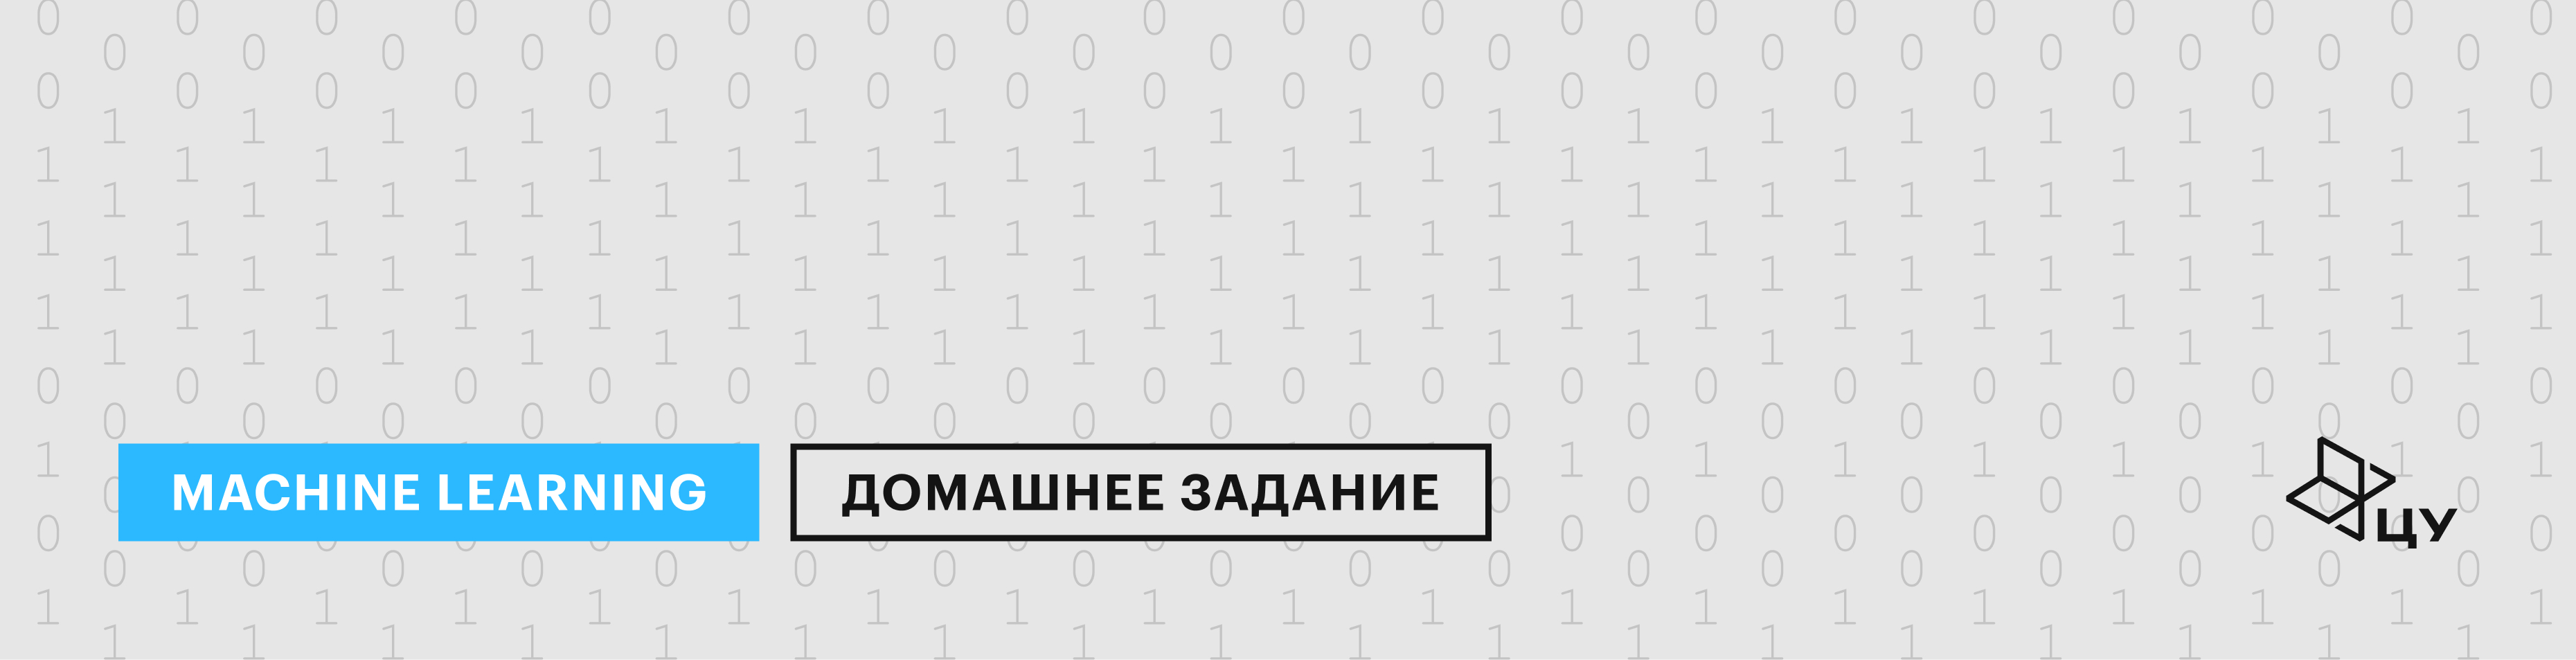

# Классификация и MSE

В этом домашнем задании мы проверяем, как выбор функции потерь и масштаб целевой переменной влияет на поведение модели в задаче классификации.
Нас будет интересовать не только то, какие метрики получаются в итоге, но и как именно модель приходит к этим результатам.

**Ниже вам предстоит выполнить несколько небольших экспериментов с кодом и ответить на тестовые вопросы.**

При проверке будет учитываться:
1.   корректность полученных ответов;
2.   корректность и воспроизводимость кода, с помощью которого они были получены.

**Обратите внимание, что одни и те же метрики могут скрывать принципиально разное поведение моделей, и это как раз то, что предстоит проверить в этом задании.**

**Важно:** Все вопросы/подзадачи внутри домашнего задания должны быть выполнены в полном объеме; частично выполненные задания приниматься не будут.

## Выбор функции потерь


В задачах классификации можно использовать разные функции потерь, включая **log_loss**, **hinge_loss** и **MSE**. Формально они все позволяют обучать модели, но приводят к разным свойствам предсказаний.
Перед тем, как приступить к выполнению задания, мы предлагаем наглядно посмотреть, чем эти подходы отличаются и какие ограничения у них возникают в задаче классификации.

Что произойдет если в задаче классификации при обучении применить MSE вместо с log_loss и hinge_loss?

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
rng = np.random.default_rng(seed=73)
class sgd_lecture_linear:
  def __init__(self, rng, MAX_ITER = 100_000):
    self.MAX_ITER = MAX_ITER
    self.w = None
    self.w0 = rng.normal()
    return

  def _f(self, x):
    assert len(x) == len(self.w)
    return np.dot(self.w, x) + self.w0

  def _der_loss(self, x, y, loss):
    if loss == 'MSE':
      return -(y - self._f(x)) * x

  def fit(self, X_train, y_train, loss = 'MSE'):
    self.w = rng.normal(size=X_train.shape[1])
    step = 0.01
    for k in range(self.MAX_ITER):
      rand_index = rng.integers(0, X_train.shape[0] - 1)
      x = np.array(X_train)[rand_index]
      y = np.array(y_train)[rand_index]
      if k % 10000 == 0:
         step = step / 2
      self.partial_fit(x, y, step, loss)

  def partial_fit(self, x, y, step = 0.01, loss = 'MSE'):
    if not self.w.any():
      self.w = rng.normal(size=len(x))
    dl = self._der_loss(x, y, loss)
    self.w -= step * dl
    self.w0 -= - step * (y - self._f(x))

  def predict_proba(self, x, loss = 'MSE'):
    x = np.array(x)
    preds = []
    pred_fuction = self._f
    for x_curr in x:
      preds.append(pred_fuction(x_curr))
    return preds

In [8]:
random_state = 73
x, y = make_classification(1_000, 7, random_state = random_state)
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

In [9]:
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, y_train)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(y_test, preds):.3f}')

0.978


Посмотрим на результат – очень неплохо!

Сравним с Logistic Regression из sklearn (обучается на logloss)

In [10]:
lr = LogisticRegression(random_state = random_state)
lr.fit(x_train, y_train)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(y_test, lr_preds):.3f}')

0.981


Обратим внимание на результат – не сказать чтобы прямо сильно отличаются качеством!

Как же так? Мы же оптимизировали MSE, а он для задач регресии!

Попробуем сломать!

Давайте заменим таргеты на -1 и 1 вместо 0 и 1

In [11]:
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, 2 * y_train - 1)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(2 * y_test - 1, preds):.3f}')

lr = LogisticRegression(random_state = random_state)
lr.fit(x_train, 2 * y_train - 1)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(2 * y_test - 1, lr_preds):.3f}')

0.977
0.981


Не сработало!

## Задание 1.1
Выберите правильный вариант ответа и подтвердите его результатом, полученным с помощью кода.

---



А если заменить таргеты 0 и 1 на -10 и 10?

1.   Метрики изменятся
2.   Метрики не изменятся

**Ответ:**

In [41]:
# INSERT YOUR CODE HERE
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, 20 * y_train - 10)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(20 * y_test - 10, preds):.3f}')

lr = LogisticRegression(random_state = random_state)
lr.fit(x_train, 20 * y_train - 10)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(20 * y_test - 10, lr_preds):.3f}')
print("="*40)
print("Ответ - 2. Метрики не изменятся")
print("="*40)

0.978
0.981
Ответ - 2. Метрики не изменятся


## То есть MSE вполне можно применять для классификации?

В целом да!     
Но мы потеряем некоторые хорошие свойства.     
Вспомним семинар – оптимизация log_loss эквивалентна максимизации правдоподобия, то есть получившиеся оценки это оценки вероятности.

Что же нам предсказал SGD с MSE?

<Axes: >

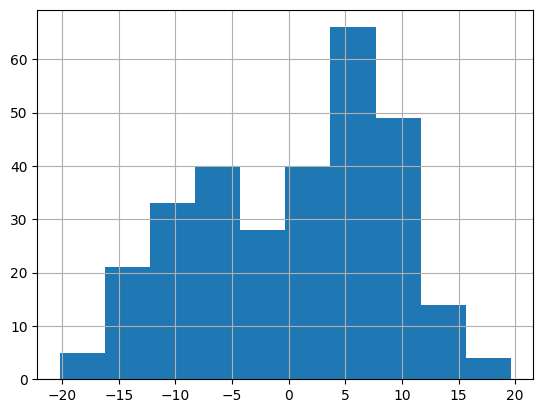

In [13]:
import pandas as pd
pd.Series(preds).hist()

Сравните с предсказаниями логистической регрессии:

<Axes: >

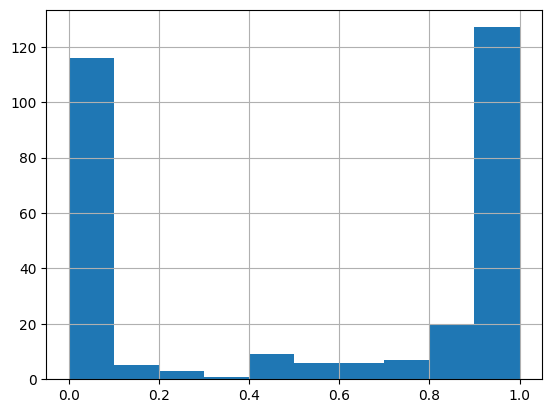

In [14]:
pd.Series(lr_preds).hist()

То есть если логистическая регрессия предсказала, например, 0.9 – в 9 случаях из 10 целевое событие произойдет

Это свойство логистической регрессии используется в моделях отклика в прайсинге, в оценке вероятности дефолта в рисках и пр.

Так что же, MSE вообще в классификации не использовать?

In [15]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

Для начала посмотрим на калибровочные кривые наших классификаторов.

Они строятся так:
1.   Бьем пространство предсказаний на равные бины – например, точки со скором от 0 до 0.2, от 0.2 до 0.4 и пр.;
2.   В каждом таком бине считаем средний скор (среднее значение всех предсказание, попавши в бин) – это горизонтальная координата;
3.   В каждом бине считаем долю единичек – это вертикальная координата;
4.   Получившиеся точки соединяем ломаной.

При идеальной калибровке средний скор будет совпадать с концентрацией риска.

Посмотрим как откалибрована логистическая регрессия:

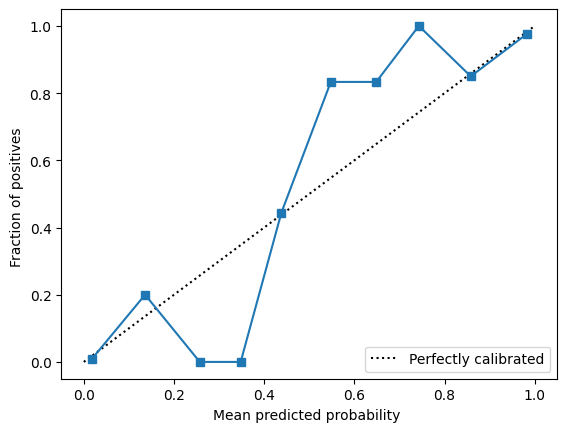

In [16]:
prob_true, prob_pred = calibration_curve(y_test, lr_preds, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, lr_preds)
disp.plot()

Почему так получилось?

Смотрим на предыдущую картинку с распределением предиктов – очень мало наблюдений попало в середину.

Теперь как калиброван наш SGD с MSE, предварительно шкалируем предикты:

In [17]:
preds = (preds - min(preds)) / max(preds - min(preds))

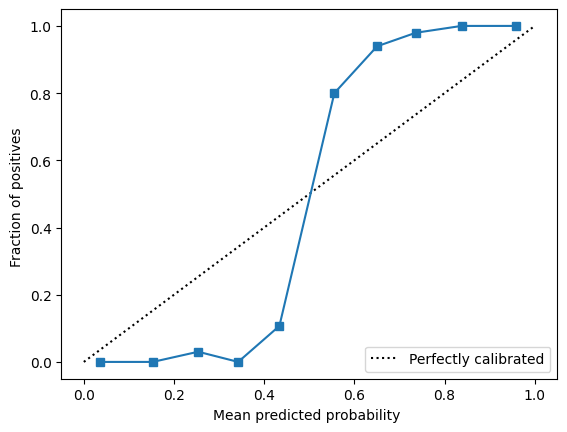

In [18]:
prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, preds)
disp.plot()

Да уж! Вот здесь точно нельзя использовать предикты как вероятность!

Но это на глаз,  а как же количественно сравнить эти две кривые?

Для этого используется специальная метрика**:

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - p_i \right)^2
$$

** это вариант sklearn, в рисках применяется после разделения на 3 части – аналогично разделению MSE на bias и variance – мы еще поговорим об этом в семинаре по ансамблям.

## Задание 1.2
Выберите правильный вариант ответа.

---




Какой известный лосс вам напомнила эта формула?

1.   huber loss
2.   MSE
3.   MSLE
4.   hinge loss
5.   log loss
6.   triplet loss



**Ответ:** 2 - MSE

## Задание 1.3
Выберите правильный вариант ответа и подтвердите его результатом, полученным с помощью кода.

---



Представьте, что данная модель используется в MedTech-системе для оценки вероятности неблагоприятного клинического события
 (например, резкого ухудшения состояния или необходимости экстренного вмешательства).

**В этой системе:**
значение предсказания интерпретируется как вероятность события
решения принимаются на основании самих чисел, а не только их порядка
ошибка в вероятности напрямую влияет на клинические решения
Для количественной оценки качества вероятностных предсказаний используется Brier Score.

В рамках данного эксперимента как отличается Brier Score у логистической регрессии (LR) и SGD c MSE?

1.   У LR в три и более раз выше
2.   У LR выше от двух до трех раз
3.   Различия несущественны,  составляют не более 10%
4.   У LR ниже от двух до трех раз
5.   У LR в три и более раз ниже

**Ответ:**

In [40]:
from sklearn.metrics import brier_score_loss, mean_squared_error
from tabulate import tabulate
# INSERT YOUR CODE HERE
bsl_lr = brier_score_loss(y_test, lr_preds)
print(f'Brier score for log-loss: {bsl_lr}')
preds = (preds - min(preds)) / max(preds - min(preds))
bsl_mse = brier_score_loss(y_test, preds)
print(f'Brier score for mse: {bsl_mse}')
print("="*40)
print("Ответ: 4 - У LR ниже от двух до трех раз")
print("="*40)

Brier score for log-loss: 0.042176354716754176
Brier score for mse: 0.11743242863579023
Ответ: 4 - У LR ниже от двух до трех раз




---


*Перед отправкой задания убедитесь, что все выбранные ответы указаны в
поле «Ответ», а код корректно запускается.*